In [ ]:
!pip install --upgrade pip --quiet

'''
This script calculates insurance payouts for each Unit Area of Insurance for the Kenya Livestock Insurance Program
Payouts are based on cumulative NDVI values for the insurance period
Insurance payouts can be calculated from years 2003-2018, for long rains (March-June) or short rains (October-December) periods
author: Sara Miller
Last Updated 4/2/19
'''

# try to import packages needed
try:
  import ee
  import folium
  from ee.ee_exception import EEException
  
  from google.colab import auth
  from pydrive.auth import GoogleAuth
  from pydrive.drive import GoogleDrive
  from oauth2client.client import GoogleCredentials


# if it doesn't work, install the packages...
except ImportError:
  !pip install -q earthengine-api
  !pip install -q folium
  !pip install -q bokeh
  
  # ...then import
  import ee
  import folium
  from ee.ee_exception import EEException


# import necessary python packages
import numpy as np
import pandas as pd
import math
import datetime
from itertools import groupby
import geopandas as gpd
from shapely.geometry import shape

     |████████████████████████████████| 153kB 5.0MB/s 


/usr/local/lib/python2.7/dist-packages/folium/__init__.py:59: UserWarning: This version of folium is the last to support Python 2. Transition to Python 3 to be able to receive updates and fixes. Check out https://python3statement.org/ for more info.
  UserWarning


In [ ]:
# try to initialize Earth Engine session
try:
  ee.Initialize()

# if it doesn't work, then authorize an account for Earth Engine to connect to...
except EEException:
  !earthengine authenticate --quiet

  authCode = raw_input("Authorization code:")

  !earthengine authenticate --authorization-code=$authCode
  
  # ...then initialize session
  ee.Initialize()

Running command using Cloud API.  Set --no-use_cloud_api to go back to using the API

Paste the following address into a web browser:

    https://accounts.google.com/o/oauth2/auth?scope=https%3A%2F%2Fwww.googleapis.com%2Fauth%2Fearthengine+https%3A%2F%2Fwww.googleapis.com%2Fauth%2Fdevstorage.full_control&redirect_uri=urn%3Aietf%3Awg%3Aoauth%3A2.0%3Aoob&response_type=code&client_id=517222506229-vsmmajv00ul0bs7p89v5m89qs8eb9359.apps.googleusercontent.com

On the web page, please authorize access to your Earth Engine account and copy the authentication code. Next authenticate with the following command:

    earthengine authenticate --authorization-code=PLACE_AUTH_CODE_HERE

Authorization code:4/rAHY2Xo5OEDUP4sknfOSWxyfmPqH0SHk6ie4fpqKJAfYeNOqW6HD58c
Running command using Cloud API.  Set --no-use_cloud_api to go back to using the API


Successfully saved authorization token.


In [ ]:
#Unit Area of Insurance shapefile
uai = ee.FeatureCollection('users/sem0029/KLIP_BORANA_CLEAN_2017')

#function to rescale NDVI from 0-200 to -1-1
def rescaleNDVI(img):
  ndvi = img.subtract(100).divide(100).rename('ndvi')
  return ndvi.updateMask(ndvi.gt(-1).And(ndvi.lt(1))).set('system:time_start',img.get('system:time_start'))

#function to mask pixels with limited temporal variability using eMODIS_FEWS_Kenya_dia_BASIS provided by KLIP
def imgmask(img):
  mask1 = ee.Image('users/sem0029/mask1').eq(0)
  return img.updateMask(mask1)

#get sMODIS NDVI, mask pixels and rescale NDVI
smodis = ee.ImageCollection('projects/servir-e-sa/sMODIS').map(imgmask).map(rescaleNDVI)

#function to convert feature class to pandas geodataframe
#from https://gis.stackexchange.com/questions/257727/iterate-over-imagecollection-returning-pandas-dataframe-using-earth-engine-pyt?noredirect=1&lq=1
def fc2df(fc):
  # Convert a FeatureCollection into a pandas GeoDataFrame
  # Features is a list of dict with the output
  features = fc.getInfo()['features']

  dictarr = []

  for f in features:
    # Store all attributes in a dict
    attr = f['properties']
    # and treat geometry separately
    attr['geometry'] = f['geometry']  # GeoJSON Feature!
    # attr['geometrytype'] = f['geometry']['type']
    dictarr.append(attr)

  df = gpd.GeoDataFrame(dictarr)
  # Convert GeoJSON features to shape
  df['geometry'] = map(lambda s: shape(s), df.geometry)    
  return df



#have user input year and rain period (short or long rains)
#return an error if parameters entered are not valid
while True:
    #have user input year
    inputyear = int(raw_input("Input year, must be between 2003 and 2018: "))
    if ((inputyear < 2003) | (inputyear > 2018)):
        print("Sorry, that is not a valid year.")
        #Return to the start of the loop
        continue
    else:
        #year is valid
        break
        
while True:
    #have user input rain period
    rainperiod = raw_input("Input rain period-type S for short rains or L for long rains. Long rains is March-June and short rains is October-December: ")
    if (rainperiod != 'L') & (rainperiod != 'l') & (rainperiod != 'S') & (rainperiod != 's'):
        print("Sorry, that is not a valid rain period.")
        #Return to the start of the loop
        continue
    else:
        #year is valid
        break

Input year, must be between 2003 and 2018: 2005
Input rain period-type S for short rains or L for long rains. Long rains is March-June and short rains is October-December: s


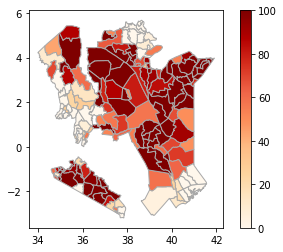

In [ ]:
#calculate long rains payouts if user input L
if rainperiod == 'L' or rainperiod == 'l':
  yr = 2003
  m = 3

  #set up empty dataframes 
  smodislrdf = gpd.GeoDataFrame()
  dictarr = []

  for yr in range(2003, 2019):
    for m in range(3, 7):
      #calculate average monthly NDVI
      sfilter = smodis.filter(ee.Filter.calendarRange(yr, yr, 'year')).filter(ee.Filter.calendarRange(m, m, 'month'))

      savg = sfilter.reduce(ee.Reducer.mean())

      #average monthly NDVI per UAI
      smonthlyuai = savg.reduceRegions(collection=uai, reducer=ee.Reducer.mean(), scale=250)


      #convert the results from Reduce.Regions into a dataframe
      sdf = fc2df(smonthlyuai)


      #try to add columns to the dataframe
      smodislrdf['avg'+str(yr)+str(m)] = sdf['mean']
      #set index of the dataframe to UAI gridcode and set geometry
      if (yr == 2018)& (m == 6):
        smodislrdf['gridcode'] = sdf['gridcode']
        smodislrdf.set_index('gridcode', inplace=True, drop=True)
        smodislrdf['geometry'] = map(lambda s: shape(s), sdf.geometry)


    #calculate cumulative seasonal NDVI
    smodislrdf['cm'+str(yr)] = smodislrdf['avg'+str(yr)+'3']+smodislrdf['avg'+str(yr)+'4']+smodislrdf['avg'+str(yr)+'5']+smodislrdf['avg'+str(yr)+'6']


  #find mean and standard deviation of NDVI from 2003-2016 per UAI
  columnlist = ['cm2003', 'cm2004', 'cm2005', 'cm2006', 'cm2007', 'cm2008', 'cm2009', 'cm2010', 'cm2011', 'cm2012', 'cm2013', 'cm2014', 'cm2015', 'cm2016']
  smodislrdf['meanndvi'] = smodislrdf[columnlist].mean(axis = 1)
  smodislrdf['stddev'] = smodislrdf[columnlist].std(axis = 1)

  for yr in range(2003, 2019):
    #calculate index values for each rain period/year/uai
    smodislrdf['index'+str(yr)] = (smodislrdf['cm'+str(yr)] - smodislrdf['meanndvi']) / smodislrdf['stddev']


  #calculate thresholds
  columnlist1 = ['index2003', 'index2004', 'index2005', 'index2006', 'index2007', 'index2008', 'index2009', 'index2010', 'index2011', 'index2012', 'index2013', 'index2014', 'index2015', 'index2016']
  smodislrdf['trigger'] = smodislrdf[columnlist1].quantile(0.2, axis = 1)
  smodislrdf['exit'] = smodislrdf[columnlist1].quantile(0.01, axis = 1)


  #calculate percent payouts
  smodislrdf['payout'+str(inputyear)] = (smodislrdf['trigger'] - smodislrdf['index'+str(inputyear)]) / (smodislrdf['trigger'] - smodislrdf['exit']) * 100
  smodislrdf['payout'+str(inputyear)] = np.where(smodislrdf['payout'+str(inputyear)]>100, 100, smodislrdf['payout'+str(inputyear)])
  smodislrdf['payout'+str(inputyear)] = np.where((smodislrdf['payout'+str(inputyear)]<5)&(smodislrdf['payout'+str(inputyear)]>0), 5, smodislrdf['payout'+str(inputyear)])
  smodislrdf['payout'+str(inputyear)] = np.where((smodislrdf['payout'+str(inputyear)]<0), 0, smodislrdf['payout'+str(inputyear)])
  with pd.option_context('display.max_rows', None, 'display.max_columns', None):
    print(smodislrdf['payout'+str(inputyear)])
  
  #plot payouts
  smodislrdf.plot(column='payout'+str(inputyear), cmap='OrRd', legend=True, edgecolor='#a9a9a9')
  

  
  
#calculate sMODIS short rains payouts if user input S
if rainperiod == 'S' or rainperiod == 's':
  yr = 2003
  m = 10

  #set up empty dataframes 
  smodissrdf = gpd.GeoDataFrame()
  dictarr = []

  for yr in range(2003, 2019):
    for m in range(10, 13):
      #calculate average monthly NDVI
      sfilter = smodis.filter(ee.Filter.calendarRange(yr, yr, 'year')).filter(ee.Filter.calendarRange(m, m, 'month'))

      savg = sfilter.reduce(ee.Reducer.mean())

      #average monthly NDVI per UAI
      smonthlyuai = savg.reduceRegions(collection=uai, reducer=ee.Reducer.mean(), scale=250)


      #convert the results from Reduce.Regions into a dataframe
      sdf = fc2df(smonthlyuai)


      #try to add columns to the dataframe
      smodissrdf['avg'+str(yr)+str(m)] = sdf['mean']
      #set index of the dataframe to UAI gridcode
      if (yr == 2018)& (m == 12):
        smodissrdf['gridcode'] = sdf['gridcode']
        smodissrdf.set_index('gridcode', inplace=True, drop=True)
        smodissrdf['geometry'] = map(lambda s: shape(s), sdf.geometry)


    #calculate cumulative seasonal NDVI
    smodissrdf['cm'+str(yr)] = smodissrdf['avg'+str(yr)+'10']+smodissrdf['avg'+str(yr)+'11']+smodissrdf['avg'+str(yr)+'12']


  #find mean and standard deviation of NDVI from 2003-2016 per UAI
  columnlist = ['cm2003', 'cm2004', 'cm2005', 'cm2006', 'cm2007', 'cm2008', 'cm2009', 'cm2010', 'cm2011', 'cm2012', 'cm2013', 'cm2014', 'cm2015', 'cm2016']
  smodissrdf['meanndvi'] = smodissrdf[columnlist].mean(axis = 1)
  smodissrdf['stddev'] = smodissrdf[columnlist].std(axis = 1)

  for yr in range(2003, 2019):
    #calculate index values for each rain period/year/uai
    #index is the standard score of cumulative ndvi for each uai
    smodissrdf['index'+str(yr)] = (smodissrdf['cm'+str(yr)] - smodissrdf['meanndvi']) / smodissrdf['stddev']


  #calculate thresholds
  #the trigger is the 20th percentile index value from 2003-2016
  #the exit is the 1st percentile index value from 2003-2016 
  columnlist1 = ['index2003', 'index2004', 'index2005', 'index2006', 'index2007', 'index2008', 'index2009', 'index2010', 'index2011', 'index2012', 'index2013', 'index2014', 'index2015', 'index2016']
  smodissrdf['trigger'] = smodissrdf[columnlist1].quantile(0.2, axis = 1)
  smodissrdf['exit'] = smodissrdf[columnlist1].quantile(0.01, axis = 1)


  
  #calculate percent payouts
  #payouts are triggered if the index value is below the trigger
  #minimum payout is 5% of the total sum insured
  #payouts are calculated linearly between the trigger and exit index values
  #payout equals (trigger-index)/(trigger-exit)
  smodissrdf['payout'+str(inputyear)] = (smodissrdf['trigger'] - smodissrdf['index'+str(inputyear)]) / (smodissrdf['trigger'] - smodissrdf['exit']) * 100
  smodissrdf['payout'+str(inputyear)] = np.where(smodissrdf['payout'+str(inputyear)]>100, 100, smodissrdf['payout'+str(inputyear)])
  smodissrdf['payout'+str(inputyear)] = np.where((smodissrdf['payout'+str(inputyear)]<5)&(smodissrdf['payout'+str(inputyear)]>0), 5, smodissrdf['payout'+str(inputyear)])
  smodissrdf['payout'+str(inputyear)] = np.where((smodissrdf['payout'+str(inputyear)]<0), 0, smodissrdf['payout'+str(inputyear)])
  #with pd.option_context('display.max_rows', None, 'display.max_columns', None):
    #print(smodissrdf['payout'+str(inputyear)])
    
  #plot payouts for each UAI on a map
  smodissrdf.plot(column='payout'+str(inputyear), cmap='OrRd', legend=True, edgecolor='#a9a9a9')